# Hotmart - Data Analyst Challenge

# Planejamento da Solução (IOT)

## Input 

 Sua tarefa será gerar Insights sobre os dados no dataset que disponibilizamos. Não existe uma forma única de chegar a uma solução, nem um número mínimo ou máximo de insights para serem gerados, mas, separamos algumas perguntas que seriam interessantes de serem respondidas:
 
1. A Hotmart depende dos maiores produtores da plataforma? Ou seja, os produtores que mais vendem são responsáveis pela maior parte do faturamento da Hotmart?
2. Existe algum padrão ou tendência relevante nos dados?
3. Há épocas do ano em que uma determinada categoria ou nicho de produto
vende mais?
4. Se tivéssemos que fazer uma campanha de Marketing incentivar mais
pessoas a criarem produtos em um determinado nicho, qual nicho seria esse?
5. Quem são os melhores clientes?
6. Quais clientes estão proximos do churn?
7. Quais os potenciais clientes para entrar no programa de fidelização?
8. Quais clientes precisam ser retidos?
9. Quais clientes mais prováveis de responder as campanhas de marketing?

## Output

* Ferramentas:
    - Metabase
    - StreamLit
* URL para o time de operação testar
* Download dos dados selecionados

## Tasks

In [ ]:
* Descrição dos dados:
    - Substituição de NA's.
   
* EDA:
    - Análise Univariada
    - Análise Bivariada
    - Detecção de Outliers
    - Seleção de Features
    - Estudo do Espaço
    - Definição do Embedding
* Treinamento dos Algoritimos de ML:
    - Análise de Performance.
    - Análise de Clustering
    - Definição dos números de clustering.
* EDA - Insights:
    - Explicação das características dos segmentos.
* Tabela para armazenar os clientes clusterizados.
* Criação do notebook de produção 
* Arquitetura da AWS:
    - S3 para armazenar os dados
    - EC2 para armazenar o etl e a ferramenta de visualização 
    - DB para armazenar a tabela
    - Cronjob 
    - Papermill

# 1 - Imports

In [34]:
import math
import inflection 
import warnings
import mysql.connector

import pandas as pd
import seaborn as sns

from sklearn import cluster as c 
from sklearn import metrics as m 
from datetime import datetime

from matplotlib import pyplot as plt

from sklearn import preprocessing as pp 

sns.set(rc={'figure.figsize':(20,10)})
warnings.filterwarnings( 'ignore' )

## 0.1 Establishing the connection 

In [4]:
conn = mysql.connector.connect(
    user='admin', password='0WHPq8U2yJ9JgHVjsRBM', host='interview-2.ck1h5ksgzpiq.us-east-1.rds.amazonaws.com', database='innodb')

## 0.2 Reading the table Into a DataFrame

In [5]:
sql_query = pd.read_sql_query('''
                             SELECT * FROM sales_data''', 
                             conn)

- loading into a CSV file

In [6]:
sql_query.to_csv('/Users/rromao/Desktop/Repos/Hotmart/Hotmart-Challenge/exported_data.csv', index=False)

# 2 - Loading Data

In [2]:
df_raw = pd.read_csv('/Users/rromao/Desktop/Repos/Hotmart/Hotmart-Challenge/exported_data.csv')

In [3]:
df_raw.head(5)

,purchase_id,product_id,affiliate_id,producer_id,buyer_id,purchase_date,product_creation_date,product_category,product_niche,purchase_value,affiliate_commission_percentual,purchase_device,purchase_origin,is_origin_page_social_network
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1663958,6640.0,209372.0,116238.0,1200397.0,2016-06-26 12:00:00,2011-03-19 15:47:36,Video,Presentation skills,-0.265302,NaN,Smart TV,Origin ef2b,"0,0"
2,1677087,2350.0,141418.0,2821.0,1083764.0,2016-06-26 12:00:00,2010-07-05 01:50:15,Podcast,Child psychology,-0.177077,NaN,Smart TV,Origin ef2b,"0,0"
3,2017360,35669.0,618642.0,618642.0,1436106.0,2016-06-26 12:00:00,2012-06-13 02:59:37,Podcast,Presentation skills,-0.468989,NaN,Smart TV,Origin ef2b,"0,0"
4,2017379,57998.0,1164511.0,70388.0,1436118.0,2016-06-26 12:00:00,2013-05-07 08:51:31,Podcast,Anxiety management,-0.401168,NaN,Smart TV,Origin ef2b,"0,0"


# 3 - Data Description

In [3]:
# Criando uma cópia para manipular a cópia do dado sem alterar 
# o Dataset Original 

df1 = df_raw.copy()

## 1.1 Rename Columns

In [4]:
df1.columns 

Index(['purchase_id', 'product_id', 'affiliate_id', 'producer_id', 'buyer_id',
       'purchase_date', 'product_creation_date', 'product_category',
       'product_niche', 'purchase_value', 'affiliate_commission_percentual',
       'purchase_device', 'purchase_origin', 'is_origin_page_social_network'],
      dtype='object')

In [5]:
cols_old = ['purchase_id', 'product_id', 'affiliate_id', 'producer_id', 'buyer_id',
       'purchase_date', 'product_creation_date', 'product_category',
       'product_niche', 'purchase_value', 'affiliate_commission_percentual',
       'purchase_device', 'purchase_origin', 'is_origin_page_social_network']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

In [13]:
# Renomeando as colunas utilizando a Biblioteca Inflection
# - Ela é uma biblioteca de transformação de Strings.
# - Ela regulariza e pluraliza palavras em inglês e transforma strings de CamelCase para Underscore

df1.columns = cols_new

## 1.2 Data Dimensions

In [14]:
print( 'Número de Linhas: {}'.format( df1.shape[0] ) )
print( 'Número de Colunas: {}'.format( df1.shape[1] ) )

Número de Linhas: 1599829
Número de Colunas: 14


## 1.3 Data Types

In [8]:
df1.dtypes

purchase_id                          int64
product_id                         float64
affiliate_id                       float64
producer_id                        float64
buyer_id                           float64
purchase_date                       object
product_creation_date               object
product_category                    object
product_niche                       object
purchase_value                     float64
affiliate_commission_percentual    float64
purchase_device                     object
purchase_origin                     object
is_origin_page_social_network       object
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

purchase_id                          0
product_id                           1
affiliate_id                         1
producer_id                          1
buyer_id                             1
purchase_date                        1
product_creation_date                1
product_category                     1
product_niche                        1
purchase_value                       1
affiliate_commission_percentual    200
purchase_device                      1
purchase_origin                      1
is_origin_page_social_network        0
dtype: int64

## 1.5 Fillout NA

In [78]:
df1.head(5)

,purchase_id,product_id,affiliate_id,producer_id,buyer_id,purchase_date,product_creation_date,product_category,product_niche,purchase_value,affiliate_commission_percentual,purchase_device,purchase_origin,is_origin_page_social_network,purchase_date_year,purchase_date_month
0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.000000,0.0,0,0,0,,
1,1663958,6640.0,209372.0,116238.0,1200397.0,2016-06-26 12:00:00,2011-03-19 15:47:36,Video,Presentation skills,-0.265302,0.0,Smart TV,Origin ef2b,"0,0",,
2,1677087,2350.0,141418.0,2821.0,1083764.0,2016-06-26 12:00:00,2010-07-05 01:50:15,Podcast,Child psychology,-0.177077,0.0,Smart TV,Origin ef2b,"0,0",,
3,2017360,35669.0,618642.0,618642.0,1436106.0,2016-06-26 12:00:00,2012-06-13 02:59:37,Podcast,Presentation skills,-0.468989,0.0,Smart TV,Origin ef2b,"0,0",,
4,2017379,57998.0,1164511.0,70388.0,1436118.0,2016-06-26 12:00:00,2013-05-07 08:51:31,Podcast,Anxiety management,-0.401168,0.0,Smart TV,Origin ef2b,"0,0",,


In [4]:
df1['product_id'].fillna(0, inplace=True)
df1['affiliate_id'].fillna(0, inplace=True)
df1['producer_id'].fillna(0, inplace=True)
df1['buyer_id'].fillna(0, inplace=True)
df1['product_category'].fillna(0, inplace=True)
df1['product_niche'].fillna(0, inplace=True)
df1['purchase_value'].fillna(0, inplace=True)
df1['affiliate_commission_percentual'].fillna(0, inplace=True)
df1['purchase_device'].fillna(0, inplace=True)
df1['purchase_origin'].fillna(0, inplace=True)


In [5]:
df1['purchase_date'].fillna(0, inplace=True)
df1['product_creation_date'].fillna(0, inplace=True)

In [6]:
df1.isna().sum()

purchase_id                        0
product_id                         0
affiliate_id                       0
producer_id                        0
buyer_id                           0
purchase_date                      0
product_creation_date              0
product_category                   0
product_niche                      0
purchase_value                     0
affiliate_commission_percentual    0
purchase_device                    0
purchase_origin                    0
is_origin_page_social_network      0
dtype: int64

In [30]:
df1.head(5)

,purchase_id,product_id,affiliate_id,producer_id,buyer_id,purchase_date,product_creation_date,product_category,product_niche,purchase_value,affiliate_commission_percentual,purchase_device,purchase_origin,is_origin_page_social_network
0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.000000,0.0,0,0,0
1,1663958,6640.0,209372.0,116238.0,1200397.0,2016-06-26 12:00:00,2011-03-19 15:47:36,Video,Presentation skills,-0.265302,0.0,Smart TV,Origin ef2b,"0,0"
2,1677087,2350.0,141418.0,2821.0,1083764.0,2016-06-26 12:00:00,2010-07-05 01:50:15,Podcast,Child psychology,-0.177077,0.0,Smart TV,Origin ef2b,"0,0"
3,2017360,35669.0,618642.0,618642.0,1436106.0,2016-06-26 12:00:00,2012-06-13 02:59:37,Podcast,Presentation skills,-0.468989,0.0,Smart TV,Origin ef2b,"0,0"
4,2017379,57998.0,1164511.0,70388.0,1436118.0,2016-06-26 12:00:00,2013-05-07 08:51:31,Podcast,Anxiety management,-0.401168,0.0,Smart TV,Origin ef2b,"0,0"


## 1.6 Change Data Types

In [7]:
df1['purchase_date'] = pd.to_datetime(df1['purchase_date'], errors='coerce')
df1['product_creation_date'] = pd.to_datetime(df1['product_creation_date'], errors='coerce')

In [8]:
df1.dtypes

purchase_id                                 int64
product_id                                float64
affiliate_id                              float64
producer_id                               float64
buyer_id                                  float64
purchase_date                      datetime64[ns]
product_creation_date              datetime64[ns]
product_category                           object
product_niche                              object
purchase_value                            float64
affiliate_commission_percentual           float64
purchase_device                            object
purchase_origin                            object
is_origin_page_social_network              object
dtype: object

In [9]:
df1['product_id'] = df1['product_id'].astype( int )
df1['affiliate_id'] = df1['affiliate_id'].astype( int )
df1['producer_id'] = df1['producer_id'].astype( int )
df1['buyer_id'] = df1['buyer_id'].astype( int )

## 1.7 Descriptive Statistics

1. Estimativas de Localização:
    
    1. Média
    2. Mediana
    3. Mínimo
    4. Máximo
    
2. Estimativas de Variabilidade:
    
    1. Desvio
    2. Variância 
    3. Desvio Padrão
    4. Range( Intervalo )
    
3. Skewness:
    
4. Kurtosis:

In [10]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

In [11]:
cols_drop = ['purchase_id','product_id','affiliate_id', 'producer_id', 'buyer_id','affiliate_id']
num_attributes = num_attributes.drop(columns= cols_drop )

### 1.7.1 Numerical attributes

In [12]:
# Estimadore de localização ( Media, Mediana, Min, Max )

est1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
est2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
est3 = pd.DataFrame( num_attributes.apply( np.min ) ).T
est4 = pd.DataFrame( num_attributes.apply( np.max ) ).T

# estimadores de variabilizade (Desvio Padrão, Range )

est5 = pd.DataFrame( num_attributes.apply( np.std ) ).T
est6 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T

# skewness e Kurtosis

est7 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
est8 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T


# Concatenando
pd.options.display.float_format = '{:.2f}'.format
m1 = pd.concat( [ est3, est4, est6, est1, est2, est5, est7, est8] ).T.reset_index()

m1.columns = ['attributes', 'min', 'max', 'range', 'media', 'mediana', 'desvio_padrao', 'skewness', 'kurtosis']

# percentis 

quartis = num_attributes.apply( lambda x: np.percentile( x, q=[10, 25, 50, 75, 95, 99] ) ).T.reset_index()
quartis.columns = ['attributes', 'P10', 'P25', 'P50', 'P75', 'P95', 'P99']

#
m2 = pd.merge(m1, quartis, how='inner', on='attributes')
m2


,attributes,min,max,range,media,mediana,desvio_padrao,skewness,kurtosis,P10,P25,P50,P75,P95,P99
0,purchase_value,-0.54,124.56,125.10,0.00,-0.35,1.00,10.82,629.21,-0.51,-0.45,-0.35,0.06,1.65,3.84
1,affiliate_commission_percentual,0.00,100.00,100.00,7.60,0.00,18.48,2.26,3.75,0.00,0.00,0.00,0.00,55.00,70.00


In [89]:
# Possíveis 

### Mínimo 


- O menor valor de um conjunto de dados

### Máximo 



- O Maior valor de um conjunto de dados

### Intervalo

- A diferença entre o maior e o menor conjunto de dados
- Mostra a Escala dos dados 

### Média

- A soma de todos os valores dividido pelo número de valores usado na soma. 
- Resume o conjunto de dados em um ponto central 

### Mediana

- O número do meio de uma lista ordenada. 
Ex.: (3 ,5 ,1 ,2 ,10 ) Ordenando a lista [ 1, 2, 3 ,5 ,10 ] Aqui a mediana é o número 3 
    
- ( 3,  1, 2, 10 ) Ordenando a lista [ 1, 2, 3, 10 ] Aqui a mediana será 2 + 3 / 2 = 2.5 

- Se o tamanho do conjunto de dados for um número par:
   - A mediana é a média dos valores centrais

- Se o tamanh do conjunto de dados for um número impar:
    - A mediana é o valor central do cojunto de dados ordenados

### Desvio Padrão 

- Estimativa de dispersão ou variabilidade 
- Mede a dispersão dos valores do conjunto de dados em torno de uma estimativa de localização ( média)

- 99% dos dados estão dentro 3 desvio padrao 
- 95% dos dados estão dentro de 2 desvio padrao
- 68% dos dados estão dentro de 1 desvio padrao  
 

Quando se trata de distribuição normal

### Skewness

- Medida de assimetria da distribuição de dados, em relação a uma distribuição normal. 
- A distribuição normal tem simetria em relação a média, ou seja, 50% do dados estão a esquerda e a direita

Ter a ideia dos numeros que mais fgrequentes aparecem nos dados. Assim, saberá a escala desses dados

- Skewness Positiva e Negativa:
    - Mediana > Média:Deslocamento para a esquerda = Skewness Negativa
    - Mediana < Média:Deslocamento para a esquerda = Skewness Positiva

### Kurtosis

 - Kurtosis evidencia as caudas longas (Probabilidades de ascotecer valores extremos, seja mínimos ou máximo)

### Quartis (Quantile)

 - Um quartil é qualquer um dos três valores que divide o conjunto de dados ordenado em 4 partes iguais, e assim, cada parte representa 1/4 da amostra original 

**Primeiro Quartil (Quartil inferior):** è o valor do conjunto de dados que delimita os 25% menores valores;

**Segundo Quartil (Quartil do meio):** è o valor do conjunto de dados que delimita os 50% menores valores;

**Terceiro Quartil (Quartil Superior):** è o valor do conjunto de dados que delimita os 75% menores valores;

### Percentis

- Os percentis são medidas que dividem a amostra orenada em 100 partes, cada uma com uma porcentagem de dados aproximadamente igual 

- O percentil 1, determina 1% dos menores valores do conjunto de dados( 1% dos dados são menores que P1)
- O percentil 10, determina 10% dos menores valores do conjunto de dados( 10% dos dados são menores que P1)
- O percentil 25, determina 25% dos menores valores do conjunto de dados( Primeiro Quartil)
- O percentil 50, determina 50% dos menores valores do conjunto de dados( Segundo Quartil = Mediana)
- O percentil 75, determina 75% dos menores valores do conjunto de dados( Terceiro Quartil)






### Boxplot

- Boxplot motra os 4 principais atributos de uma variável: Centro, variabilidade, assimetria, outliers. 
-Violinplot mostra os 5 principais atributos de uma variável: Centro, Variabilidade, assimetria, outliers e densidade

<AxesSubplot:xlabel='affiliate_commission_percentual'>

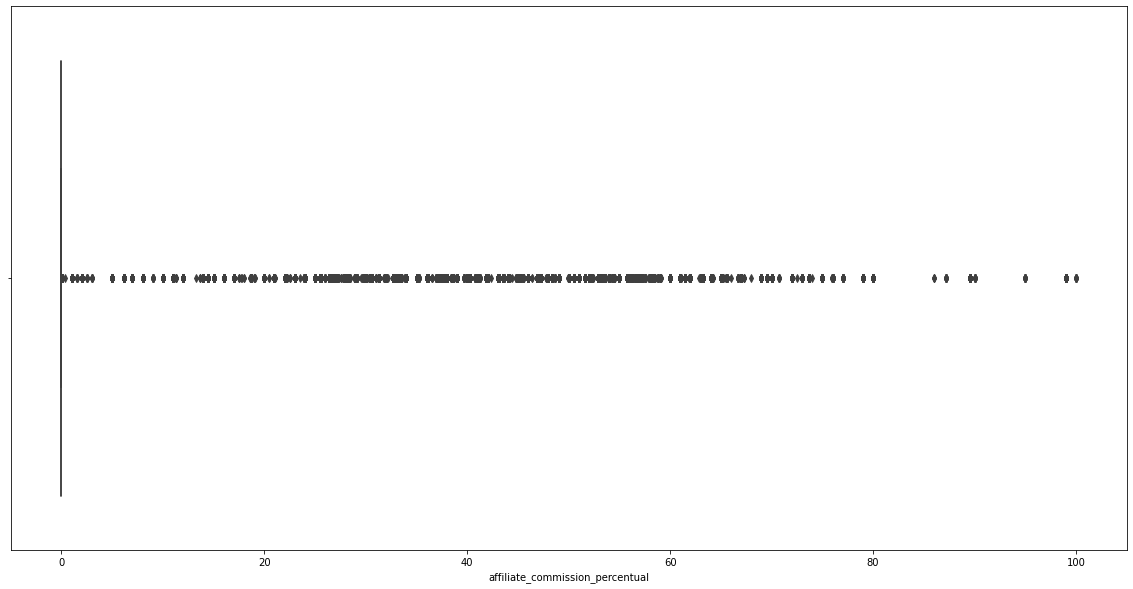

In [90]:
plt.figure( figsize=(20,10) )
sns.boxplot( x='affiliate_commission_percentual', whis=124, data=num_attributes)

In [80]:
Q3 = 0.06
Q1 = - 0.45
Q3 + 1.5*( Q3 - Q1 )

0.825

In [29]:
np.quantile(num_attributes['purchase_value'], q=[0.25, 0.50,0.75] )

array([-0.453015 , -0.349998 ,  0.0649229])

In [35]:
# Minimo = 
# Quartil 01 = 
# Quartil 02 = mediana = 
# Quartil 03 = 
# Maximo = 
# Outliers = 

In [ ]:
#minimum = Q1 - 1.5 * ( Q3 - Q1 )
#maximum = Q3 + 1.5 * ( Q3 - Q1 )

#if minimum > valor_minimo_do_conjunto_de_dados:
#    print(num_attributes['purchase_value'].min() )
#else:
#    print(minimum)

#if maximum > valor_maximo_do_conjunto_de_dados:
#    print(valor_maximo_do_conjunto_de_dados )
#else: 
#    print( maximum)

In [32]:
Q3 = 0.064
Q1 = -0.453
Q2 = -0.349

Q3 + 1.5 * (Q3 - Q1)

# A linha fora do quadrado deveria ser o valor abaixo, pois qualquer valor acima desse seria um outlier

0.8395000000000001

In [34]:
Q1 - 1.5 * (Q3 - Q1)

-1.2285000000000001

<AxesSubplot:xlabel='purchase_value'>

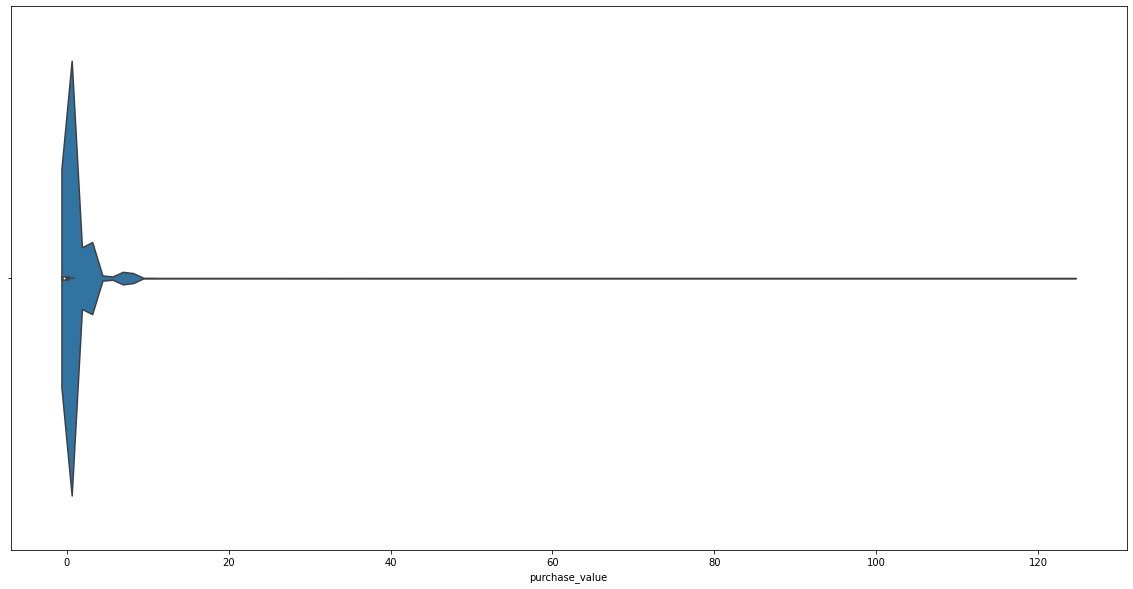

In [44]:
plt.figure(figsize=(20,10 ))

sns.violinplot(x='purchase_value', data=num_attributes)

<AxesSubplot:xlabel='affiliate_commission_percentual', ylabel='Percent'>

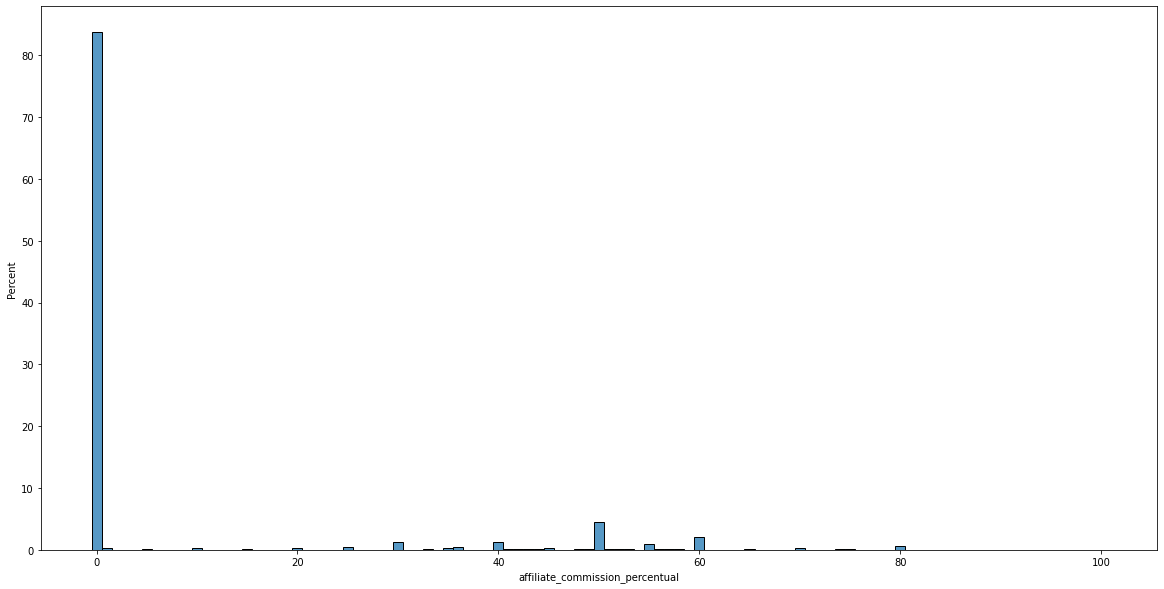

In [91]:
plt.figure(figsize=(20,10 ))
sns.histplot(x='affiliate_commission_percentual', data=num_attributes, stat="percent", discrete=True)

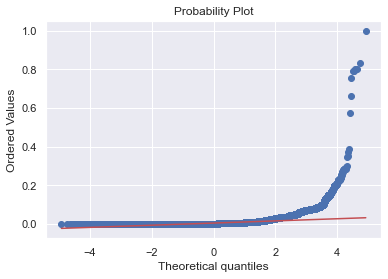

In [33]:
from scipy import stats
sns.set(rc={'figure.figsize':(20,10)})
stats.probplot(df1['purchase_value'], dist='norm', plot=plt)
plt.show()

### 1.7.2 Categorical Attributes

In [13]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

product_category                   11
product_niche                      26
purchase_device                     6
purchase_origin                  9604
is_origin_page_social_network       3
dtype: int64

<AxesSubplot:xlabel='product_category', ylabel='Percent'>

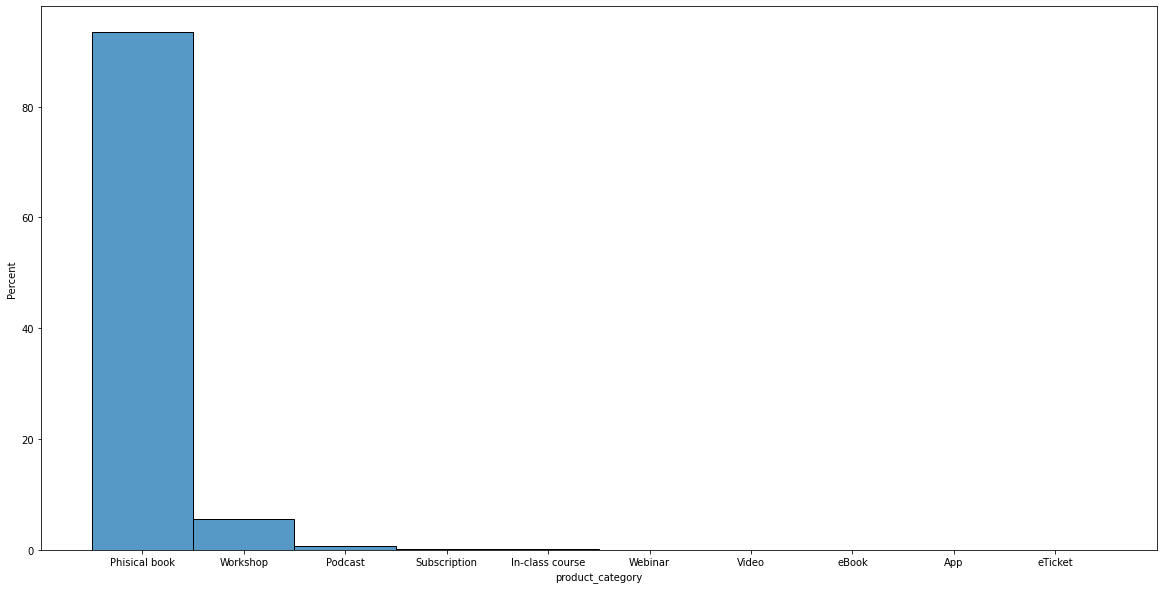

In [14]:
aux = df1[(df1['product_category'] != '0') & (df1['purchase_value'] > 0)]



plt.figure(figsize=(20,10 ))
sns.histplot(x='product_category', data=aux, stat="percent", discrete=True)

In [15]:
count_product_by_niche = df1[['buyer_id', 'product_niche']].groupby('product_niche').count().reset_index()


# 4 - Data Filtering

In [53]:
df2 = df1.copy()
df2.head(5)

,purchase_id,product_id,affiliate_id,producer_id,buyer_id,purchase_date,product_creation_date,product_category,product_niche,purchase_value,affiliate_commission_percentual,purchase_device,purchase_origin,is_origin_page_social_network
0,0,0,0,0,0,1970-01-01 00:00:00,1970-01-01 00:00:00,0,0,0.00,0.00,0,0,0
1,1663958,6640,209372,116238,1200397,2016-06-26 12:00:00,2011-03-19 15:47:36,Video,Presentation skills,-0.27,0.00,Smart TV,Origin ef2b,"0,0"
2,1677087,2350,141418,2821,1083764,2016-06-26 12:00:00,2010-07-05 01:50:15,Podcast,Child psychology,-0.18,0.00,Smart TV,Origin ef2b,"0,0"
3,2017360,35669,618642,618642,1436106,2016-06-26 12:00:00,2012-06-13 02:59:37,Podcast,Presentation skills,-0.47,0.00,Smart TV,Origin ef2b,"0,0"
4,2017379,57998,1164511,70388,1436118,2016-06-26 12:00:00,2013-05-07 08:51:31,Podcast,Anxiety management,-0.40,0.00,Smart TV,Origin ef2b,"0,0"


# 5 - Feature Engineering

In [43]:
# Fato

Compra = Fato (Soma, Contar, Maior, Menor, Media, Mediana)
Cliente entrou na base = Fato
Devolução = Fato

# Dimensão

# Tempo( Ano, mês, dia, hora, minuto)
# Espaço ( Localização, região, lat, long, bairro, rua )
# Produto( Nome, Tipo, Categoria, Preço, Condição de Compra)
# Marketing (Organica, Paid ( Facebook, Google))

SyntaxError: invalid syntax (3186136201.py, line 4)

In [97]:
df2.shape

(1599829, 14)

In [17]:
# Monetario
df_monetary = df2[['buyer_id', 'purchase_value']].groupby('buyer_id').sum().reset_index()


# Recency - Last day Purchase
df_recency = df2[['buyer_id', 'purchase_date']].groupby('buyer_id').max().reset_index()
df_recency['recency_days'] = (df2['purchase_date'].max() - df2['purchase_date'] ).dt.days
df_recency = df_recency[['buyer_id', 'recency_days']].copy()
df_ref = pd.merge(df_recency, df_monetary, on='buyer_id', how='left')

# Frequency
df_freq = df2[['buyer_id', 'purchase_id']].drop_duplicates().groupby('buyer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='buyer_id', how='left')

In [67]:
# year
df2['year'] = df2['purchase_date'].dt.year

# month
df2['month'] = df2['purchase_date'].dt.month

# day
df2['day'] = df2['purchase_date'].dt.day

# week of year
df2['week_of_year'] = df2['purchase_date'].dt.weekofyear

# year week
df2['year_week'] = df2['purchase_date'].dt.strftime( '%Y-%W' )

In [ ]:
A Hotmart depende dos maiores produtores da plataforma? Ou seja, os produtores que mais vendem são responsáveis pela maior parte do faturamento da Hotmart?
Existe algum padrão ou tendência relevante nos dados?
Há épocas do ano em que uma determinada categoria ou nicho de produto vende mais?
Se tivéssemos que fazer uma campanha de Marketing incentivar mais pessoas a criarem produtos em um determinado nicho, qual nicho seria esse?
Quem são os melhores clientes?
Quais clientes estão proximos do churn?
Quais os potenciais clientes para entrar no programa de fidelização?
Quais clientes precisam ser retidos?
Quais clientes mais prováveis de responder as campanhas de marketing?

In [19]:
df2['month'].head()

0    1
1    6
2    6
3    6
4    6
Name: month, dtype: int64

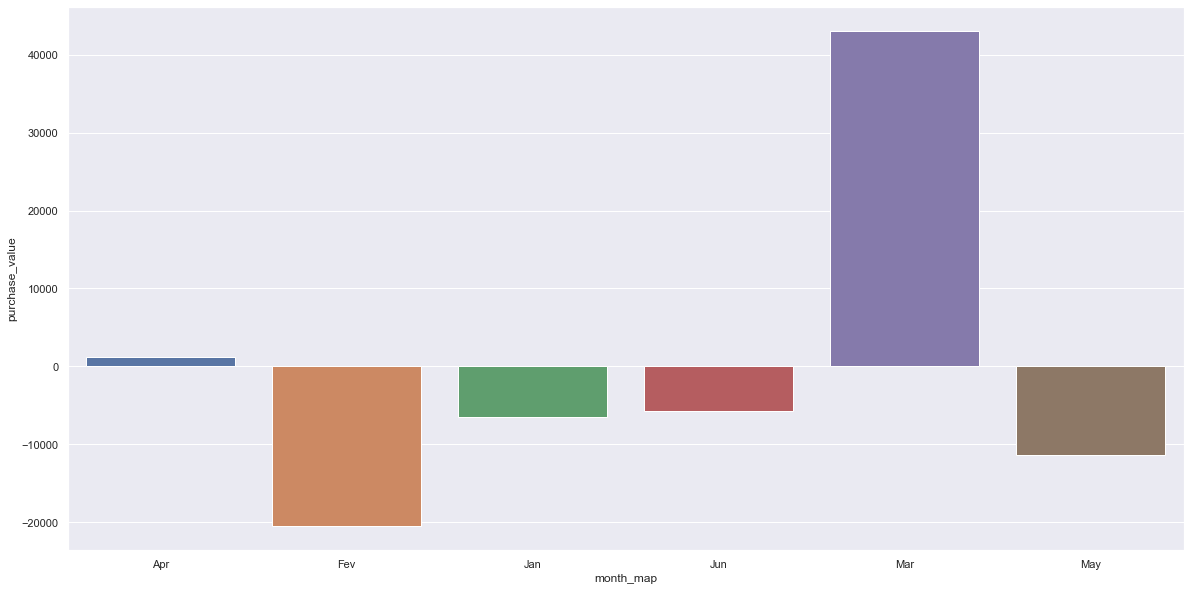

In [55]:

month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df2['month_map'] = df2['purchase_date'].dt.month.map( month_map )
aux2 = df2[['month_map', 'purchase_value']].groupby( 'month_map' ).sum().reset_index()
sns.barplot( x='month_map', y='purchase_value', hue=None, data=aux2 );

<AxesSubplot:xlabel='year'>

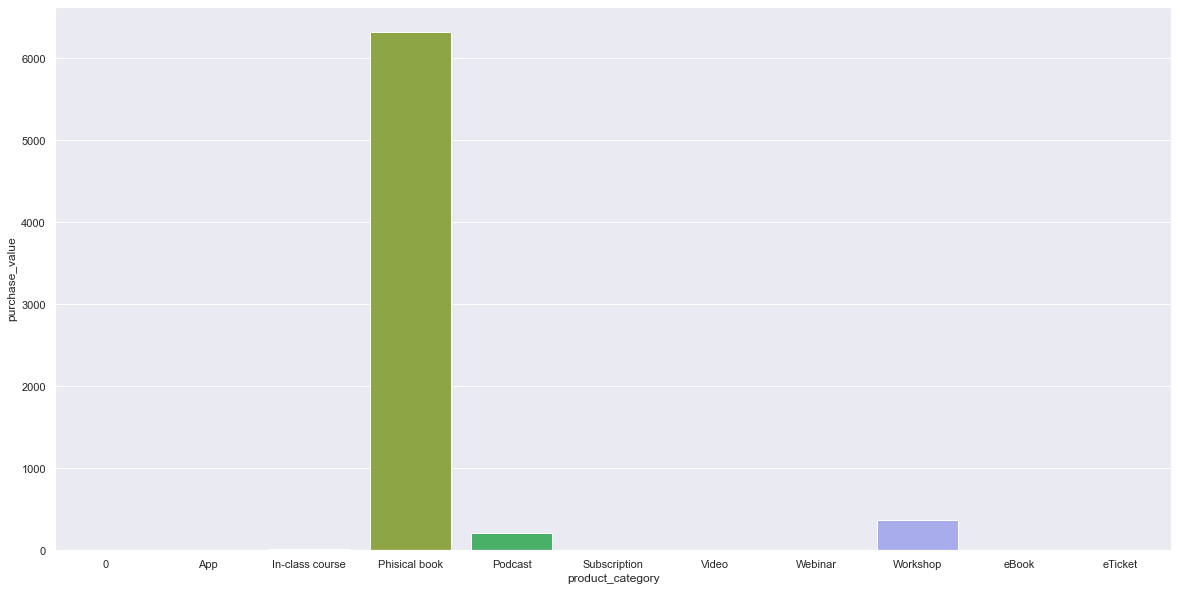

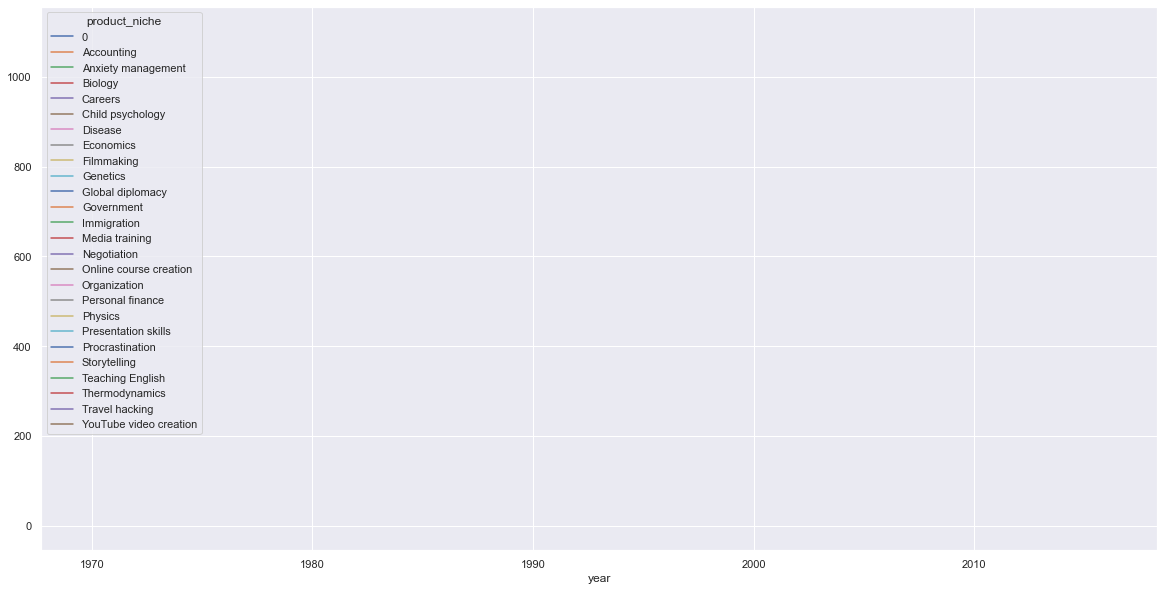

In [39]:
# Producers com mais cursos vendem mais? 

aux1 = df2[['product_category', 'purchase_value']].groupby( 'product_category' ).sum().reset_index()
sns.barplot( x='product_category', y='purchase_value', data=aux1 );


aux2 = df2[['year', 'product_niche', 'purchase_value']].groupby( ['year','product_niche'] ).sum().reset_index()
aux2.pivot( index='year', columns='product_niche', values='purchase_value' ).plot()


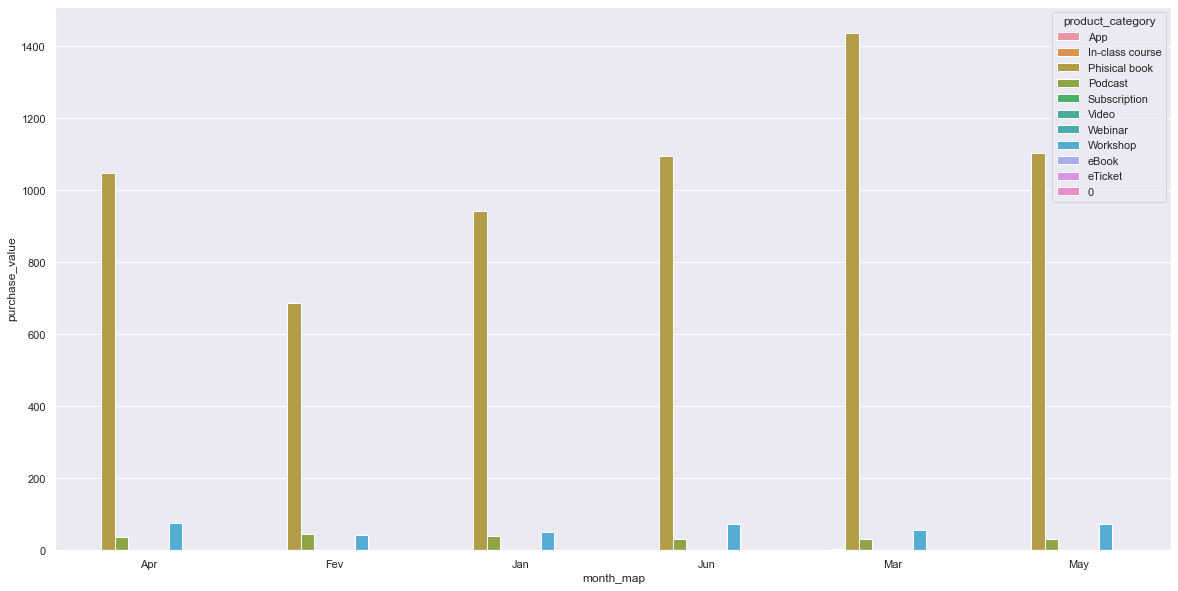

In [38]:
aux4 = df2[['month_map', 'product_category', 'purchase_value']].groupby( ['month_map', 'product_category'] ).sum().reset_index()
sns.barplot( x='month_map', y='purchase_value', hue='product_category', data=aux4 );

In [71]:
# Validando quantidade de vendas por ano. 
aux33 = df2[['producer_id','purchase_value', 'year']].groupby('year').count().reset_index()
aux33.head(5)

,year,producer_id,purchase_value
0,1970,1,1
1,2016,1599828,1599828


In [74]:
results = df2[['month_map','purchase_value']].groupby('month_map').sum().reset_index()
results.head()

,month_map,purchase_value
0,Apr,1177.75
1,Fev,-20452.01
2,Jan,-6568.18
3,Jun,-5726.42
4,Mar,43003.22


<BarContainer object of 6 artists>

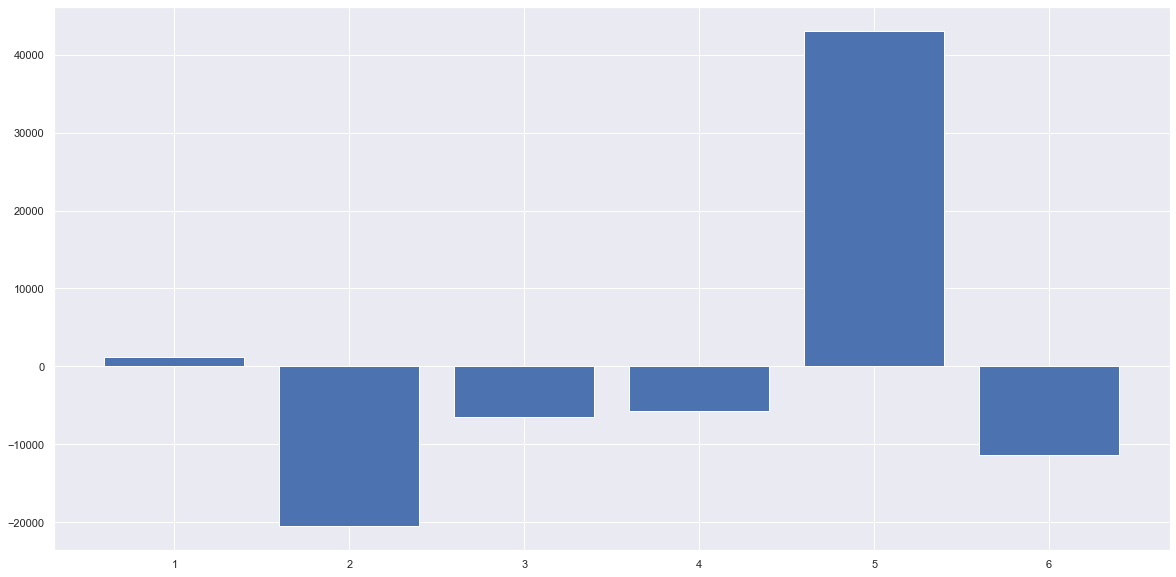

In [91]:
month = range(1,7)
plt.bar(month, results['purchase_value'] )


In [110]:
aux10 = df2[['producer_id', 'affiliate_id','purchase_value']].groupby('producer_id').sum().reset_index()
aux10.sort_values(by='purchase_value', ascending=False)

,producer_id,affiliate_id,purchase_value
249,42346,562412557,24506.56
4452,3425706,12904634502,9579.47
3116,1931767,10316061852,8004.61
995,409590,745380339,6596.96
2141,1058799,2781030447,6558.26
...,...,...,...
557,166090,6086709687,-9271.32
4416,3382787,73640451494,-9299.17
1101,464846,55956251720,-12437.50
5003,3992235,113018786383,-13566.50


In [132]:
# Quantidade de compras que foram efetuada diretamente pelo produtor, não tiveram afiliados intermediando. 

with_affiliates = df2[df2['producer_id'] == df2['affiliate_id']]
non_affiliates = df2[df2['producer_id'] != df2['affiliate_id']]


print('Foram {} compras que tiveram afiliados como intermediário no processo da compra'.format(with_affiliates.shape[0]))
print('Foram {} compras que não tiveram afiliados como intermediário no processo da compra'.format(non_affiliates.shape[0]))


Foram 1247083 compras que tiveram afiliados como intermediário no processo da compra
Foram 352746 compras que não tiveram afiliados como intermediário no processo da compra


In [152]:
# Das Compras efetuadas por intermédio de um afiliado qual foi a maior compra


test = with_affiliates[[ 'producer_id','purchase_value', 'affiliate_commission_percentual']].groupby('producer_id').max().reset_index()
test.sort_values(by='purchase_value', ascending=False)

,producer_id,purchase_value,affiliate_commission_percentual
5954,5230700,124.56,0.00
924,409590,48.26,0.00
5737,4993899,46.32,0.00
2984,1968219,43.35,0.00
5265,4554369,42.63,0.00
...,...,...,...
263,55338,-0.54,0.00
6137,5379733,-0.54,0.00
7576,7341877,-0.54,0.00
7031,6545494,-0.54,0.00


In [178]:
with_affiliates[(with_affiliates[ 'product_category'] == 0)].count()

purchase_id                        1
product_id                         1
affiliate_id                       1
producer_id                        1
buyer_id                           1
purchase_date                      1
product_creation_date              1
product_category                   1
product_niche                      1
purchase_value                     1
affiliate_commission_percentual    1
purchase_device                    1
purchase_origin                    1
is_origin_page_social_network      1
month_map                          1
year                               1
month                              1
day                                1
week_of_year                       1
year_week                          1
dtype: int64

# 6 - EDA - Space Study

# 7 - Data Preparation

In [23]:
df2 = df1.copy()

In [24]:
#plt.figure( figsize=(20,10 ))
#sns.set(rc={'figure.figsize':(20,10)})
#sns.distplot(num_attributes['purchase_value'])

mms = pp.MinMaxScaler()
df2['purchase_value'] = mms.fit_transform( df2[['purchase_value']])

# 8 - Feature Selection

In [179]:
X = df2.copy()

In [181]:
X.head()

,purchase_id,product_id,affiliate_id,producer_id,buyer_id,purchase_date,product_creation_date,product_category,product_niche,purchase_value,affiliate_commission_percentual,purchase_device,purchase_origin,is_origin_page_social_network,month_map,year,month,day,week_of_year,year_week
0,0,0,0,0,0,1970-01-01 00:00:00,1970-01-01 00:00:00,0,0,0.00,0.00,0,0,0,Jan,1970,1,1,1,1970-00
1,1663958,6640,209372,116238,1200397,2016-06-26 12:00:00,2011-03-19 15:47:36,Video,Presentation skills,-0.27,0.00,Smart TV,Origin ef2b,"0,0",Jun,2016,6,26,25,2016-25
2,1677087,2350,141418,2821,1083764,2016-06-26 12:00:00,2010-07-05 01:50:15,Podcast,Child psychology,-0.18,0.00,Smart TV,Origin ef2b,"0,0",Jun,2016,6,26,25,2016-25
3,2017360,35669,618642,618642,1436106,2016-06-26 12:00:00,2012-06-13 02:59:37,Podcast,Presentation skills,-0.47,0.00,Smart TV,Origin ef2b,"0,0",Jun,2016,6,26,25,2016-25
4,2017379,57998,1164511,70388,1436118,2016-06-26 12:00:00,2013-05-07 08:51:31,Podcast,Anxiety management,-0.40,0.00,Smart TV,Origin ef2b,"0,0",Jun,2016,6,26,25,2016-25


In [182]:
cols_drop = ['purchase_id','product_id','affiliate_id', 'producer_id', 'buyer_id','affiliate_id','purchase_date', 'product_creation_date', 'product_category', 'product_niche', 'purchase_device', 'purchase_origin', 'is_origin_page_social_network' ]
X = df1.drop(columns= cols_drop )

# 9 - Hiperparameter Fine Tuning

## 9.1 K-means

In [ ]:
clusters = [ 10 ]

silhouette_list = []
davies_list     = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans( init='random', n_clusters= k, n_init=10, max_iter=100, random_state=42)

    
    # model training
    kmeans_model.fit( X )
    
    
    # model predict
    labels = kmeans_model.predict( X )
    
    # model performance
    sil = m.silhouette_score( X, labels )
    dav = m.davies_bouldin_score( X, labels)
    
    silhouette_list.append( sil )
    davies_list.append( dav )

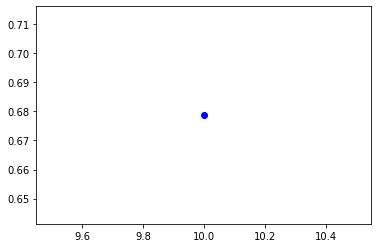

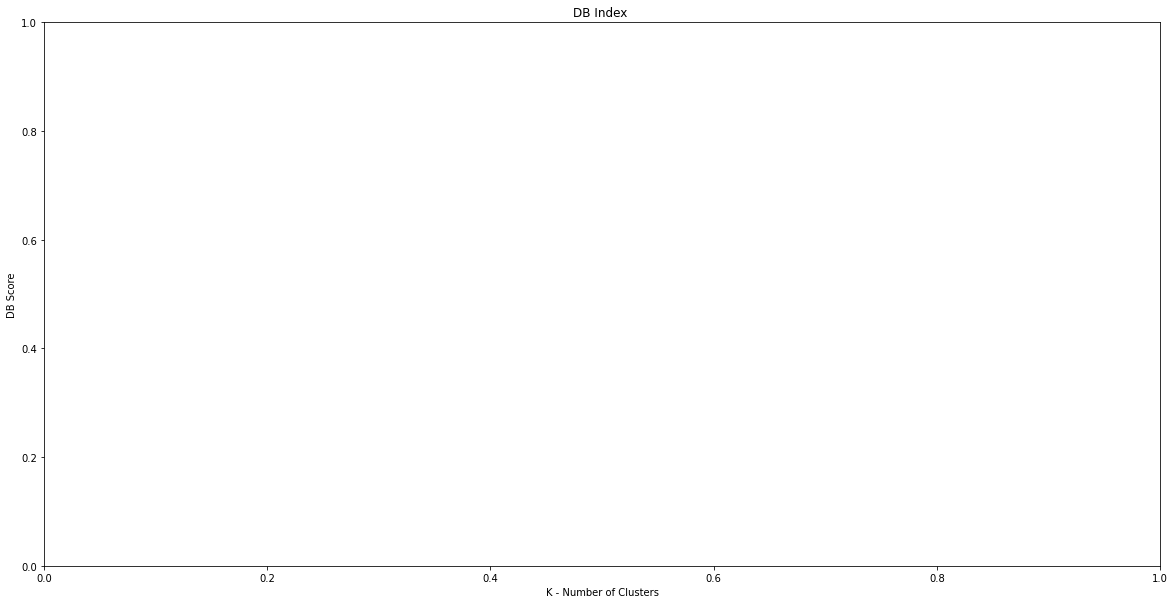

In [68]:
plt.plot( clusters, davies_list, linestyle='--', marker='o', color='b')

plt.figure( figsize=( 20,10 ))
plt.xlabel( 'K - Number of Clusters' )
plt.ylabel( 'DB Score' )
plt.title( 'DB Index ' );


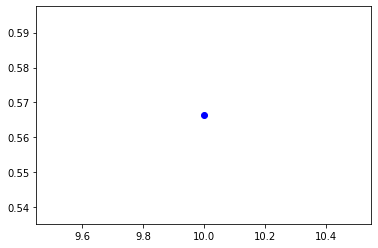

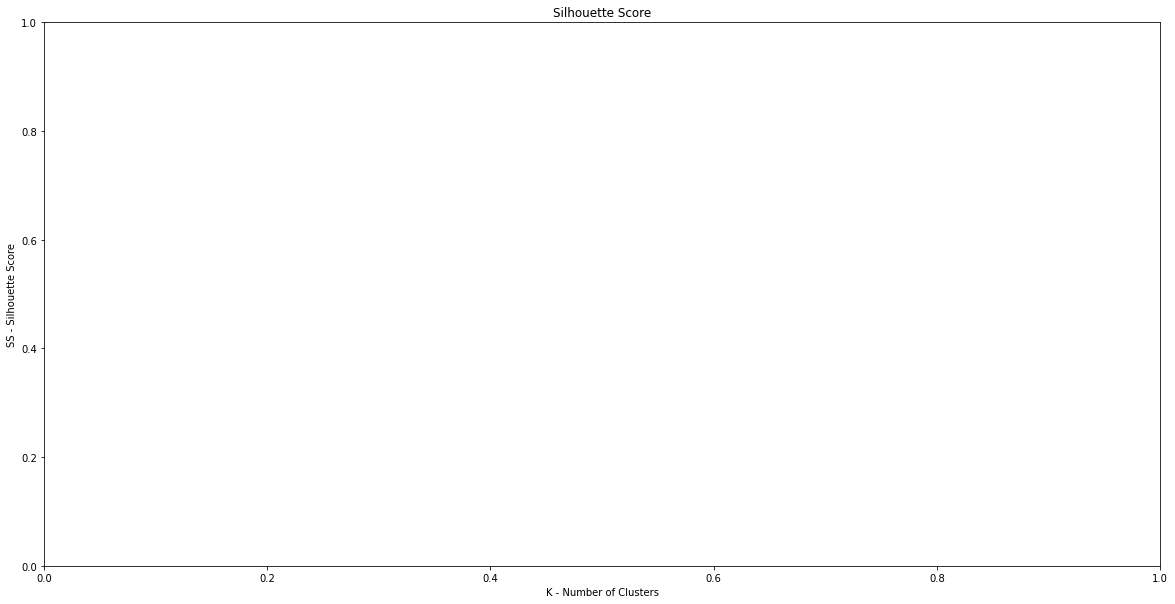

In [69]:
plt.plot( clusters, silhouette_list, linestyle='--', marker='o', color='b')

plt.figure( figsize=( 20,10 ))
plt.xlabel( 'K - Number of Clusters' )
plt.ylabel( 'SS - Silhouette Score' )
plt.title( 'Silhouette Score' );



# 10 - Machine Learn Training

# 11 - Clustering Analysis

# 12 - EDA - Inside Reports

# 13 - Deploy to Production

In [97]:
cols_drop = ['purchase_date_year', 'purchase_date_month']
df1 = df1.drop(cols_drop, axis=1)